# In this notebook we reproduce Figure 2 of the paper.

In [1]:
import sys
import os
import json
import networkx as nx

# Since we are in a sub-package, ensure that the top-level package is on the Python path
sys.path.append(os.path.abspath(os.path.join('..', '..')))

# Now we can import modules from python_fbas
from python_fbas.fbas_graph import FBASGraph
from python_fbas.fbas_graph_analysis import is_fba_resilient_approx
from python_fbas.constellation.constellation import *
import python_fbas.constellation.config as config

# %load_ext line_profiler

For each number of organization, we generate 50 random single-universe regular FBA systems and we then compute 3 overlays: constellation, a random Erdos-Renyi graph that is FBA-resilient and has diameter 2, and an overlay obtained using the greedy strategy. We then plot statistics including average degree, median degree, and max degree.

In [ ]:

import time


NUM_SAMPLES=50
# NUM_ORGS_SEQUENCE=[7, 16, 25, 50, 75, 100, 125, 150, 175, 200]
NUM_ORGS_SEQUENCE=[7,16,25,50]
constellation_overlays:dict[int,list[nx.Graph]] = {n : list() for n in NUM_ORGS_SEQUENCE}
erdos_renyi:dict[int,list[nx.Graph]] = {n : list() for n in NUM_ORGS_SEQUENCE}
greedy:dict[int,list[nx.Graph]] = {n : list() for n in NUM_ORGS_SEQUENCE}
for NUM_ORGS in NUM_ORGS_SEQUENCE:
    # we'll cache results in 'data/tmp/':
    dir = f"data/tmp/{NUM_ORGS}"
    os.makedirs(dir, exist_ok=True)

    # First, we create NUM_SAMPLES random single-universe FBA systems with 16 validators each.
    fbases = []
    for i in range(NUM_SAMPLES):
        f = f'{dir}/fbas_{i}.json'
        if os.path.exists(f):
            with open(f, 'r') as f:
                fbases.append(json.load(f))
            continue
        else:
            # random thresholds between 1/2 and 5/6 of the number of validators with 5 different thresholds
            fbas = random_single_universe_regular_fbas(NUM_ORGS, int(NUM_ORGS/2), int(5*NUM_ORGS/6), 5)
            fbases.append(fbas)
            with open(f, 'w') as f:
                json.dump(fbas, f)

    # For each FBAS, compute the constellation overlay:
    config.max_num_clusters = 4 if NUM_ORGS <= 50 else 3
    config.min_cluster_size = int((NUM_ORGS//config.max_num_clusters)*0.70)
    for i, fbas in enumerate(fbases):
        f = f'{dir}/overlay_{i}.json'
        if os.path.exists(f):
            with open(f, 'r') as f:
                constellation_overlays[NUM_ORGS].append(nx.node_link_graph(json.load(f)))
            continue
        else:
            # compute the constellation overlay and measure how long it takes:
            start_time = time.time()
            overlay = constellation_overlay(fbas)
            end_time = time.time()
            constellation_overlays[NUM_ORGS].append(overlay)
            # We save the overlay to a file for examination
            with open(f, 'w') as f:
                json.dump(nx.node_link_data(overlay), f)
        # if it took more than 20 seconds, increase min_cluster_size by 5%, unless it is already equal to NUM_ORGS/max_num_clusters:
        if end_time - start_time > 20:
            new_size = int(config.min_cluster_size * 1.05)
            if new_size < NUM_ORGS/config.max_num_clusters:
                config.min_cluster_size = new_size
            print(f"min_cluster_size increased to {config.min_cluster_size}")

    # Now the Erdos-Renyi graphs:
    # We generate a random Erdos-Renyi graph with edge probability k/N for k from 1 to N until we find a graph that has diameter 2 and that is FBA-resilient.
    for i, fbas in enumerate(fbases):
        fbas_graph:FBASGraph = single_universe_regular_fbas_to_fbas_graph(fbas)
        vertices = fbas_graph.vertices()
        validators = fbas_graph.validators
        overlay = {}
        f = f'{dir}/erdos_renyi_{i}.json'
        if os.path.exists(f):
            with open(f, 'r') as f:
                overlay = nx.node_link_graph(json.load(f))
            erdos_renyi[NUM_ORGS].append(overlay)
        else:
            for d in range(10, len(validators)):
                overlay = nx.erdos_renyi_graph(len(validators), d/len(validators))
                # relabel with the validator names:
                overlay = nx.relabel_nodes(overlay, {i: v for i, v in enumerate(validators)})
                if is_fba_resilient_approx(fbas_graph, overlay) and nx.diameter(overlay) == 2:
                    break
            with open(f, 'w') as f:
                json.dump(nx.node_link_data(overlay), f)
            erdos_renyi[NUM_ORGS].append(overlay)

    # Finally, the greedy graphs:
    for i, fbas in enumerate(fbases):
        f = f'{dir}/greedy_{i}.json'
        if os.path.exists(f):
            with open(f, 'r') as f:
                overlay = nx.node_link_graph(json.load(f))
            greedy[NUM_ORGS].append(overlay)
            continue
        else:
            overlay = greedy_overlay(fbas)
            with open(f, 'w') as f:
                json.dump(nx.node_link_data(overlay), f)
            greedy[NUM_ORGS].append(overlay)

KeyboardInterrupt: 

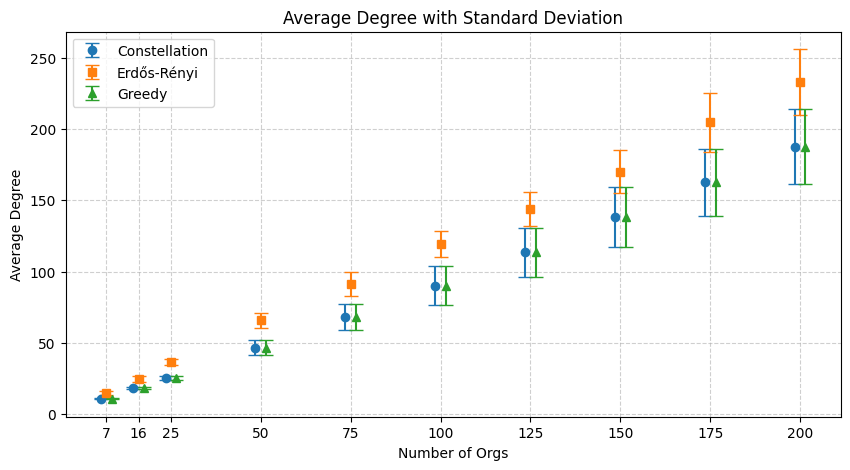

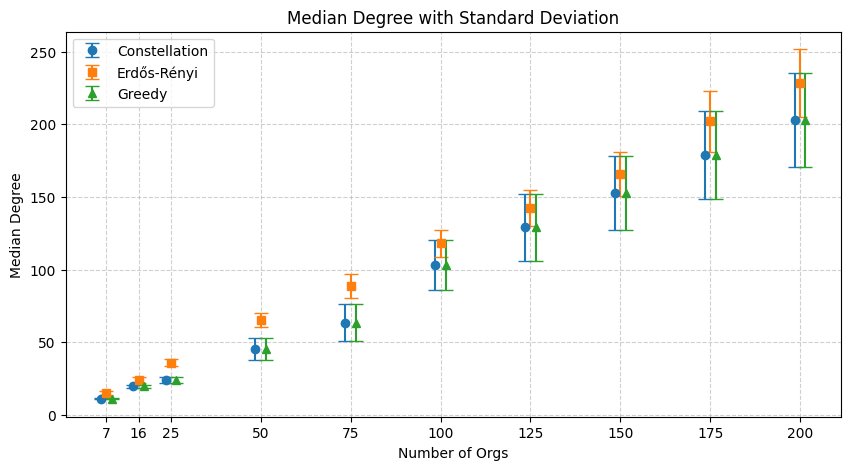

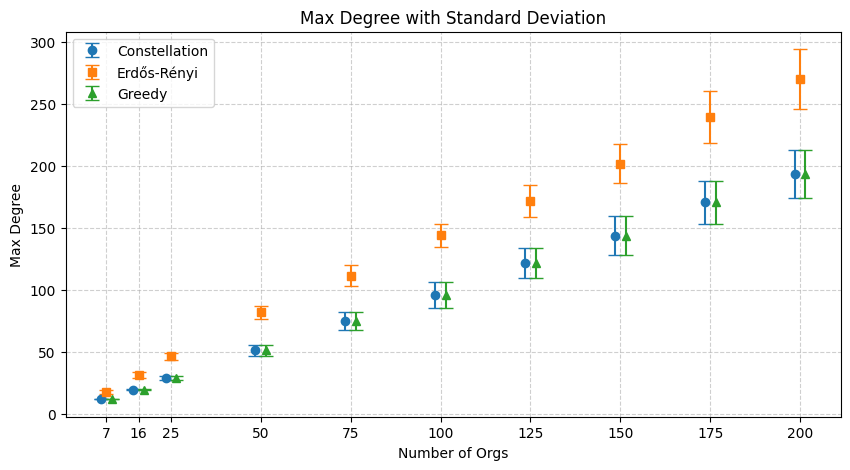

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import statistics

# Functions to compute different degree statistics
def avg_degree(graph):
    return sum([d for _, d in graph.degree()]) / len(graph)

def median_degree(graph):
    return statistics.median([d for _, d in graph.degree()])

def max_degree(graph):
    return max([d for _, d in graph.degree()])

def avg_statistic(overlays, func):
    return sum([func(graph) for graph in overlays]) / len(overlays)

def median_statistic(overlays, func):
    return statistics.median([func(graph) for graph in overlays])

def stddev_statistic(overlays, func):
    return statistics.stdev([func(graph) for graph in overlays])

# Compute statistics for each number of organizations
def compute_stats(data):
    return {
        n: [
            avg_statistic(data[n], avg_degree), 
            median_statistic(data[n], median_degree), 
            avg_statistic(data[n], max_degree),
            stddev_statistic(data[n], avg_degree),  # Stddev for mean plot
            stddev_statistic(data[n], median_degree),  # Stddev for median plot
            stddev_statistic(data[n], max_degree)  # Stddev for max plot
        ] for n in NUM_ORGS_SEQUENCE
    }

# Compute data for both models
constellation_data = compute_stats(constellation_overlays)
erdos_renyi_data = compute_stats(erdos_renyi)
greedy_data = compute_stats(greedy)

# Extract data for plotting
num_orgs = np.array(NUM_ORGS_SEQUENCE)

# Plot function
def plot_data(stat_index, ylabel, title):
    # Extract statistics
    constellation_means = [constellation_data[n][stat_index] for n in num_orgs]
    constellation_stddevs = [constellation_data[n][stat_index + 3] for n in num_orgs]
    erdos_renyi_means = [erdos_renyi_data[n][stat_index] for n in num_orgs]
    erdos_renyi_stddevs = [erdos_renyi_data[n][stat_index + 3] for n in num_orgs]
    greedy_means = [greedy_data[n][stat_index] for n in num_orgs]
    greedy_stddevs = [greedy_data[n][stat_index + 3] for n in num_orgs]
    
    # Offset for separation
    offset = 1.5
    x_constellation = num_orgs - offset
    x_erdos_renyi = num_orgs
    x_greedy = num_orgs + offset

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.errorbar(x_constellation, constellation_means, yerr=constellation_stddevs, fmt='o', label='Constellation', capsize=5)
    plt.errorbar(x_erdos_renyi, erdos_renyi_means, yerr=erdos_renyi_stddevs, fmt='s', label='Erdős-Rényi', capsize=5)
    plt.errorbar(x_greedy, greedy_means, yerr=greedy_stddevs, fmt='^', label='Greedy', capsize=5)

    # Labels and legend
    plt.xlabel("Number of Orgs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(num_orgs)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()

# Generate three plots: Mean, Median, Max Degree
plot_data(0, "Average Degree", "Average Degree with Standard Deviation")
plot_data(1, "Median Degree", "Median Degree with Standard Deviation")
plot_data(2, "Max Degree", "Max Degree with Standard Deviation")
